# Histopathologic Cancer Detection

## Step 1 Berief description

Histopathology is the study of the signs of the disease using the microscopic examination of a biopsy or surgical specimen that is processed and fixed onto glass slides. To visualize different components of the tissue under a microscope, the sections are dyed with one or more stains.

Our goal is to create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans.

In this dataset, you are provided with a large number of small pathology images to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. You are predicting the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import matplotlib.image as mpimg

In [2]:
train_labels_path=r'E:\Jia\Desktop\MS-DS\5511 Introduction to Deep Learning\week3\assessment\train_labels.csv\train_labels.csv'
sample_submission_path=r'E:\Jia\Desktop\MS-DS\5511 Introduction to Deep Learning\week3\assessment\sample_submission.csv\sample_submission.csv'
train_labels = pd.read_csv(train_labels_path)
sample_submission = pd.read_csv(sample_submission_path)

In [3]:
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [4]:
sample_submission.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


## Step2 EDA
### 2.1 Inspect and visualize data

In [5]:
import os
train_path = r'E:\Jia\Desktop\MS-DS\5511 Introduction to Deep Learning\week3\assessment\train'
test_path = r'E:\Jia\Desktop\MS-DS\5511 Introduction to Deep Learning\week3\assessment\test'
print(len(os.listdir(train_path)))
print(len(os.listdir(test_path)))

220026
57458


In [6]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [7]:
train_labels['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

<BarContainer object of 2 artists>

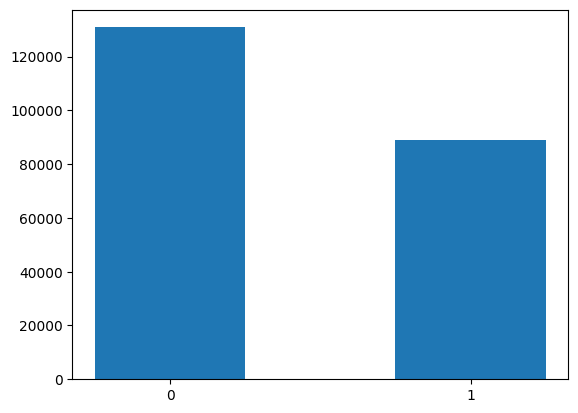

In [8]:
data = {'0':130908, '1':89117}
x = list(data.keys())
y = list(data.values())
plt.bar(x, y, width=0.5)

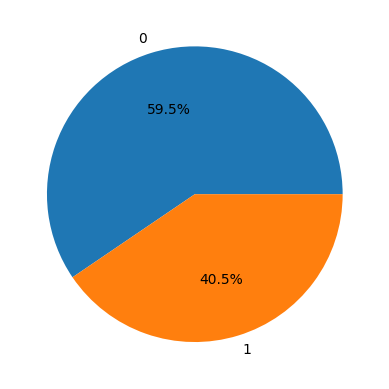

In [9]:
plt.pie(y, labels=x, autopct='%1.1f%%')
plt.show()

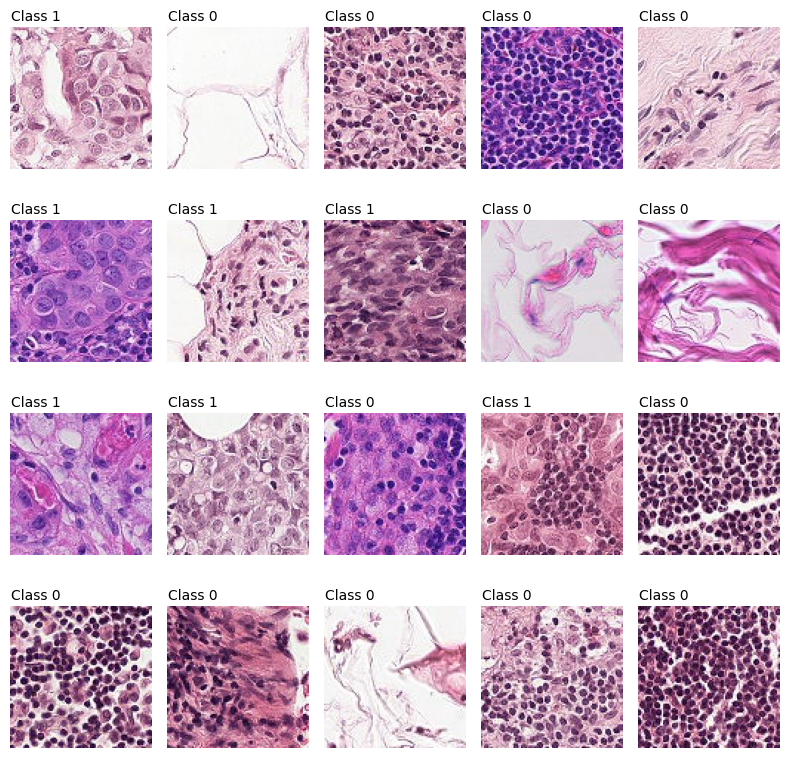

In [10]:
sample = train_labels.sample(n=20).reset_index()

plt.figure(figsize=(8,8))

for i, row in sample.iterrows():

    img = mpimg.imread(f'E:/Jia/Desktop/MS-DS/5511 Introduction to Deep Learning/week3/assessment/train/{row.id}.tif')    
    label = row.label

    plt.subplot(4,5,i+1)
    plt.imshow(img)
    plt.text(0, -5, f'Class {label}', color='k')
        
    plt.axis('off')

plt.tight_layout()
plt.show()

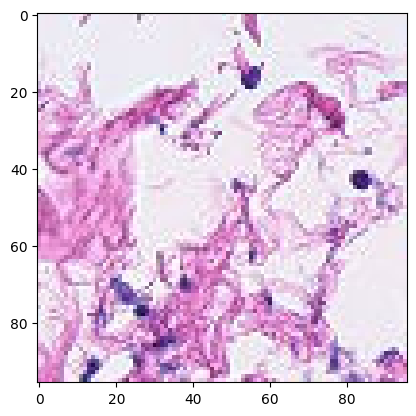

In [11]:
img = mpimg.imread(f'E:/Jia/Desktop/MS-DS/5511 Introduction to Deep Learning/week3/assessment/train/0000d563d5cfafc4e68acb7c9829258a298d9b6a.tif')
imgplot = plt.imshow(img)

In [12]:
print(img.shape)

(96, 96, 3)


The training set contains 220,025 unique images and the test set contains about 57,458.

 The images are 96x96x3 and we know that the "3" is the RGB channel.

###  2.2 Sampling and split data

Since the train dataset contains 220025 images we can sample out a shuffled part of that, in this case 100000 samples and split to train and valid data.

What we will do with the image data is shuffle the data so that the model doesn't learn based on the image ordering/pattern of input, which could potentially have consequences in the model training. We will also split the data into training and validation set to improve model development. During training we will also normalize the pixels by dividing by 255.0, which should help data processing and model training.

In [13]:
from random import sample
train_positive = train_labels[train_labels['label']==1].sample(50000, random_state=123)
train_negative = train_labels[train_labels['label']==0].sample(50000, random_state=123)

In [14]:
from sklearn.utils import shuffle
df = shuffle(pd.concat([train_positive, train_negative], axis=0),random_state=111).reset_index()

In [15]:
df

,index,id,label
0,50180,837c2b7c1c122797b87d3ee151888fa49bcec998,0
1,97504,d222c915bfadebbdcfed1bb410677435dfa5af36,0
2,134238,1ad6c04aa107e4b4200a6b6965fbc0aa7b910191,0
3,214820,e234bf4072f7fdda80bc445b284579b1eb46b9ff,1
4,41295,833dd173e5723b6b9f6dda6b0f79f65720d8e4d2,0
...,...,...,...
99995,90836,7b2bf113c078ed306ed55c0b9e9d325a90ff108c,0
99996,211500,6f913604d1877715c95cf4d60ca3ab6f420f2f9b,1
99997,35749,5a7f35fe361ff265ee55a5a46b1bdf139535f4e9,1
99998,10810,79d1f6cefe606607051d7c519dbb529ce9c6ee49,1


In [16]:
from sklearn.model_selection import train_test_split
df_train, df_valid = train_test_split(df, test_size=0.2, random_state=123)

In [17]:
df_train['id'] = df_train['id']+'.tif'
df_valid['id'] = df_valid['id']+'.tif'

In [18]:
df_train

,index,id,label
22302,215999,3d56cf04530f5a9c1ab6c44a2a1b0bd3139577aa.tif,1
49609,126254,e649cb5c196abe6832fa91759550795a9c974701.tif,0
89251,142714,a7819aaa5f4753ad30a654c6135a79452249ed04.tif,1
96385,22380,3e23846953bd98c822bb67c61a7a9f37a71bf143.tif,1
17569,2292,63e55fffd2d6c385252f481fc8dbe38205e4f5e4.tif,1
...,...,...,...
63206,191137,70141998d570932ff8e9f51ab136ef22c0d9b7a1.tif,0
61404,33792,e097bdb34ace175034a03c08a3942568708a20f8.tif,1
17730,199720,89d2ac96b4da92b082873f4addba6bf847c1ef71.tif,0
28030,126193,394efa4b804979b82fa4ddf17bdd812d1a03371d.tif,1


In [19]:
df_train['label'] = df_train['label'].astype(str)
df_valid['label'] = df_valid['label'].astype(str)

In [20]:
df_train

,index,id,label
22302,215999,3d56cf04530f5a9c1ab6c44a2a1b0bd3139577aa.tif,1
49609,126254,e649cb5c196abe6832fa91759550795a9c974701.tif,0
89251,142714,a7819aaa5f4753ad30a654c6135a79452249ed04.tif,1
96385,22380,3e23846953bd98c822bb67c61a7a9f37a71bf143.tif,1
17569,2292,63e55fffd2d6c385252f481fc8dbe38205e4f5e4.tif,1
...,...,...,...
63206,191137,70141998d570932ff8e9f51ab136ef22c0d9b7a1.tif,0
61404,33792,e097bdb34ace175034a03c08a3942568708a20f8.tif,1
17730,199720,89d2ac96b4da92b082873f4addba6bf847c1ef71.tif,0
28030,126193,394efa4b804979b82fa4ddf17bdd812d1a03371d.tif,1


## Step3 Model architecture

In [21]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow import keras
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.layers import PReLU
from keras.initializers import Constant
from tensorflow.keras.optimizers import RMSprop,Adam,SGD,Adadelta

Generate training data

In [22]:
datagen = ImageDataGenerator(rescale=1./255.)

train_generator = datagen.flow_from_dataframe(
        dataframe = df_train,
        directory = train_path,
        x_col = "id",
        y_col = "label", 
        batch_size = 64,
        seed = 123,
        shuffle = True,
        class_mode = "binary",
        target_size=(96,96))

Found 80000 validated image filenames belonging to 2 classes.


Generate validation data

In [23]:
valid_generator = datagen.flow_from_dataframe(
        dataframe = df_valid,
        directory = train_path,
        x_col = "id",
        y_col = "label", 
        batch_size = 64,
        seed = 123,
        shuffle = True,
        class_mode = "binary",
        target_size=(96,96))

Found 20000 validated image filenames belonging to 2 classes.


In [24]:
tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()

### 3.1 Initial model with optimization method Adam

In [25]:
# Initial model with 3 sets of 2 convolutional layers
np.random.seed(123)
tf.random.set_seed(123)
#ROC_1 = tf.keras.metrics.AUC()
with strategy.scope():
    model1 = Sequential()
    model1.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
    model1.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
    model1.add(MaxPooling2D(2,2))
    model1.add(Dropout(0.5))
    model1.add(BatchNormalization())

    model1.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model1.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model1.add(MaxPooling2D(2,2))
    model1.add(Dropout(0.5))
    model1.add(BatchNormalization())

    model1.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
    model1.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
    model1.add(MaxPooling2D(2,2))
    model1.add(Dropout(0.5))
    model1.add(BatchNormalization())

#     model1.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
#     model1.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
#     model1.add(MaxPooling2D(2,2))
#     model1.add(Dropout(0.5))
#     model1.add(BatchNormalization())

    model1.add(Flatten())
    model1.add(Dense(1, activation='sigmoid'))

    model1.compile(loss='binary_crossentropy', metrics=['accuracy'])
    
    #build model by input size
    model1.build(input_shape=(64, 96, 96, 3))

In [26]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (64, 94, 94, 16)          448       
                                                                 
 conv2d_1 (Conv2D)           (64, 92, 92, 16)          2320      
                                                                 
 max_pooling2d (MaxPooling2D  (64, 46, 46, 16)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (64, 46, 46, 16)          0         
                                                                 
 batch_normalization (BatchN  (64, 46, 46, 16)         64        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (64, 44, 44, 32)          4

In [27]:
optimizer = tf.keras.optimizers.Adam(0.001)
model1.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.AUC()])

In [28]:
history1 = model1.fit(train_generator,  epochs=10, validation_data = valid_generator)

Epoch 1/10
1250/1250 [==============================] - 1643s 1s/step - loss: 0.5026 - accuracy: 0.7701 - auc: 0.8445 - val_loss: 2.0943 - val_accuracy: 0.6134 - val_auc: 0.6330
Epoch 2/10
1250/1250 [==============================] - 1854s 1s/step - loss: 0.4256 - accuracy: 0.8141 - auc: 0.8867 - val_loss: 0.9225 - val_accuracy: 0.7110 - val_auc: 0.7448
Epoch 3/10
1250/1250 [==============================] - 1636s 1s/step - loss: 0.3972 - accuracy: 0.8272 - auc: 0.9022 - val_loss: 0.7421 - val_accuracy: 0.7295 - val_auc: 0.8121
Epoch 4/10
1250/1250 [==============================] - 1545s 1s/step - loss: 0.3802 - accuracy: 0.8332 - auc: 0.9111 - val_loss: 0.6388 - val_accuracy: 0.7418 - val_auc: 0.9035
Epoch 5/10
1250/1250 [==============================] - 1516s 1s/step - loss: 0.3710 - accuracy: 0.8370 - auc: 0.9156 - val_loss: 0.4527 - val_accuracy: 0.8033 - val_auc: 0.9124
Epoch 6/10
1250/1250 [==============================] - 1632s 1s/step - loss: 0.3585 - accuracy: 0.8454 - auc:

In [31]:
history1.history

{'loss': [0.5025820136070251,
  0.42559877038002014,
  0.39719098806381226,
  0.38017526268959045,
  0.3710269331932068,
  0.3585154712200165,
  0.3477095365524292,
  0.334647536277771,
  0.32471728324890137,
  0.31654462218284607],
 'accuracy': [0.770087480545044,
  0.814050018787384,
  0.8271750211715698,
  0.8331500291824341,
  0.8369625210762024,
  0.8454124927520752,
  0.8501124978065491,
  0.8563874959945679,
  0.8628875017166138,
  0.86576247215271],
 'auc': [0.844480574131012,
  0.8867218494415283,
  0.9022015929222107,
  0.9110850691795349,
  0.9156495928764343,
  0.9214792847633362,
  0.9263745546340942,
  0.9319649934768677,
  0.9359974265098572,
  0.9393259882926941],
 'val_loss': [2.094338893890381,
  0.9225346446037292,
  0.7421345710754395,
  0.6387687921524048,
  0.4526635706424713,
  0.521024763584137,
  0.4291391968727112,
  0.5674134492874146,
  0.6517170667648315,
  0.533426821231842],
 'val_accuracy': [0.6133999824523926,
  0.7109500169754028,
  0.7294999957084656,

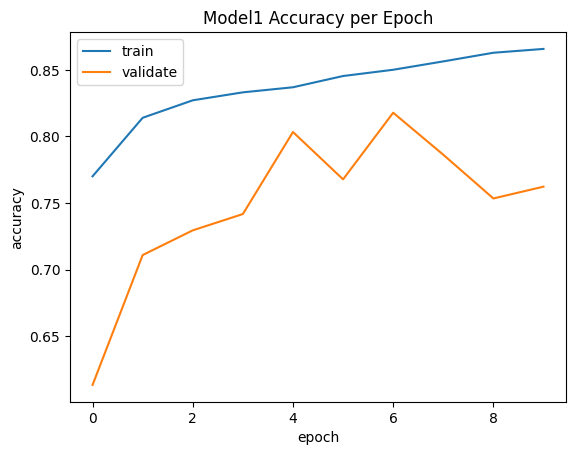

In [29]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model1 Accuracy per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch') 
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

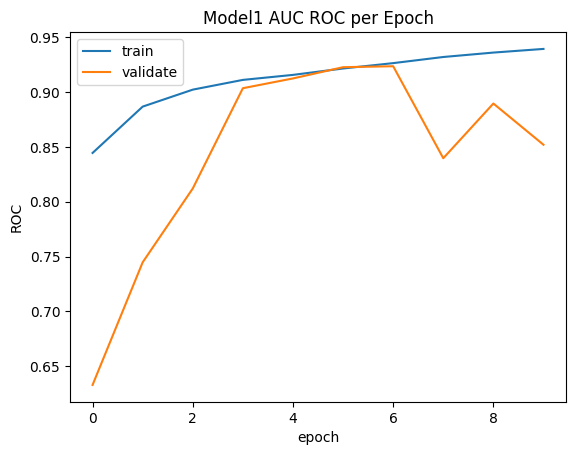

In [32]:
plt.plot(history1.history['auc'])
plt.plot(history1.history['val_auc'])
plt.title('Model1 AUC ROC per Epoch')
plt.ylabel('ROC')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

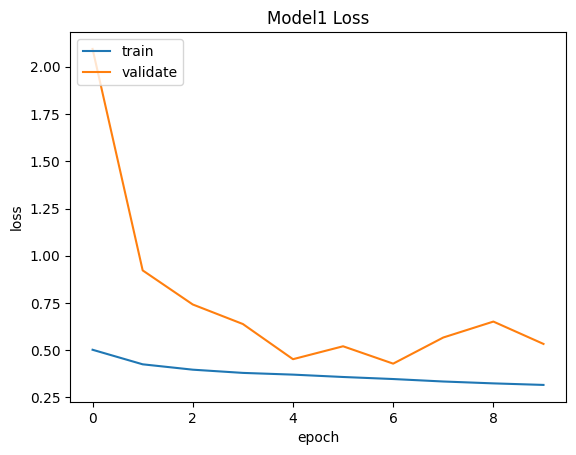

In [33]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model1 Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

###  3.2 Initial model with optimization method RMSprop

In [42]:
np.random.seed(123)
tf.random.set_seed(123)
#ROC_1 = tf.keras.metrics.AUC()
with strategy.scope():
    model2 = Sequential()
    model2.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
    model2.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
    model2.add(MaxPooling2D(2,2))
    model2.add(Dropout(0.5))
    model2.add(BatchNormalization())

    model2.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model2.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model2.add(MaxPooling2D(2,2))
    model2.add(Dropout(0.5))
    model2.add(BatchNormalization())

    model2.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
    model2.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
    model2.add(MaxPooling2D(2,2))
    model2.add(Dropout(0.5)) 
    model2.add(BatchNormalization())

#     model2.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
#     model2.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
#     model2.add(MaxPooling2D(2,2))
#     model2.add(Dropout(0.5))
#     model2.add(BatchNormalization())

    model2.add(Flatten())
    model2.add(Dense(1, activation='sigmoid'))

    
    model2.compile(loss='binary_crossentropy', metrics=['accuracy'])
    
    #build model by input size
    model2.build(input_shape=(64, 96, 96, 3))

In [43]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (64, 94, 94, 16)          448       
                                                                 
 conv2d_19 (Conv2D)          (64, 92, 92, 16)          2320      
                                                                 
 max_pooling2d_9 (MaxPooling  (64, 46, 46, 16)         0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (64, 46, 46, 16)          0         
                                                                 
 batch_normalization_9 (Batc  (64, 46, 46, 16)         64        
 hNormalization)                                                 
                                                                 
 conv2d_20 (Conv2D)          (64, 44, 44, 32)         

In [44]:
optimizer2 = tf.keras.optimizers.RMSprop(0.001)
model2.compile(loss='binary_crossentropy', optimizer=optimizer2, metrics=['accuracy', tf.keras.metrics.AUC()])

In [45]:
history2 = model2.fit(train_generator,  epochs=10 , validation_data = valid_generator)

Epoch 1/10
1250/1250 [==============================] - 3164s 3s/step - loss: 0.4883 - accuracy: 0.7813 - auc_3: 0.8550 - val_loss: 0.5283 - val_accuracy: 0.7630 - val_auc_3: 0.8824
Epoch 2/10
1250/1250 [==============================] - 894s 716ms/step - loss: 0.4150 - accuracy: 0.8190 - auc_3: 0.8937 - val_loss: 0.5501 - val_accuracy: 0.7875 - val_auc_3: 0.8549
Epoch 3/10
1250/1250 [==============================] - 515s 412ms/step - loss: 0.3881 - accuracy: 0.8312 - auc_3: 0.9074 - val_loss: 1.0652 - val_accuracy: 0.6977 - val_auc_3: 0.8590
Epoch 4/10
1250/1250 [==============================] - 836s 668ms/step - loss: 0.3705 - accuracy: 0.8388 - auc_3: 0.9158 - val_loss: 0.3661 - val_accuracy: 0.8409 - val_auc_3: 0.9208
Epoch 5/10
1250/1250 [==============================] - 1789s 1s/step - loss: 0.3524 - accuracy: 0.8477 - auc_3: 0.9241 - val_loss: 0.4271 - val_accuracy: 0.8224 - val_auc_3: 0.9299
Epoch 6/10
1250/1250 [==============================] - 1344s 1s/step - loss: 0.3390

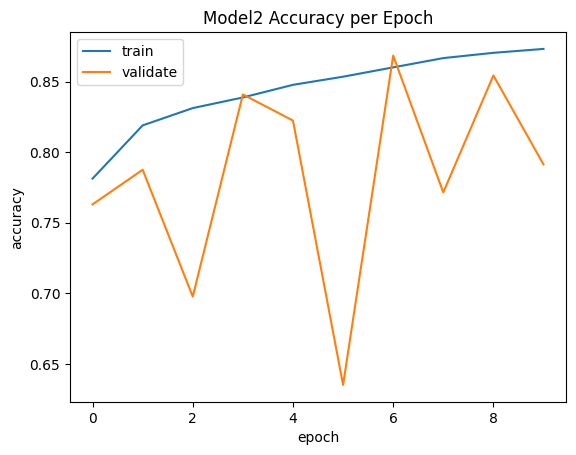

In [46]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model2 Accuracy per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch') 
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

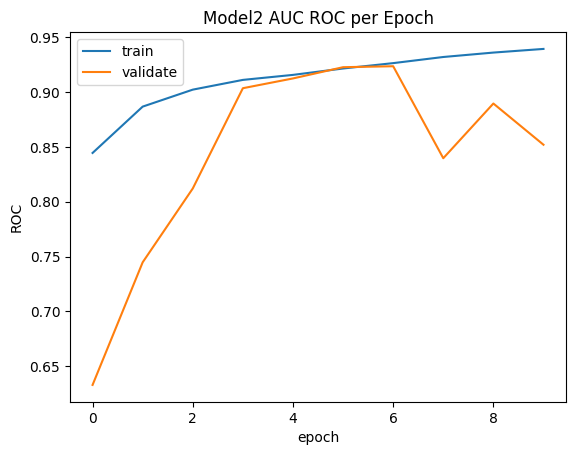

In [49]:
plt.plot(history1.history['auc'])
plt.plot(history1.history['val_auc'])
plt.title('Model2 AUC ROC per Epoch')
plt.ylabel('ROC')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

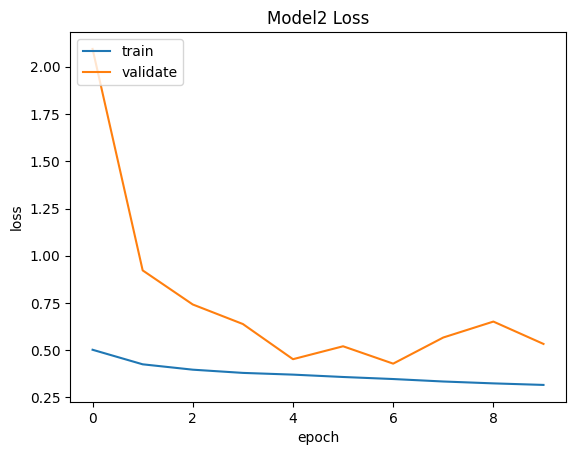

In [50]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model2 Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

## Step 4 Results and analysis

Histopathology is the study of the signs of the disease using the microscopic examination of a biopsy or surgical specimen that is processed and fixed onto glass slides. To visualize different components of the tissue under a microscope, the sections are dyed with one or more stains. In this dataset, you are provided with a large number of small pathology images to classify.  The training set contains 220,025 unique images and the test set contains about 57,458. There are 59.5% which is 130908 is labeled "0" which means non cancer, and the rest of them 40.5% (89117) is labeled "1" which means cancer. The images are 96x96x3 and we know that the "3" is the RGB channel.

Since the train dataset contains 220025 images we can sample out a shuffled part of that, in this case 100000 samples and split to train and valid data. Then I randomly choose 50000 positive train data and 50000 negative data to create a new balanced dataset. What we will do with the image data is shuffle the data so that the model doesn't learn based on the image ordering/pattern of input, which could potentially have consequences in the model training. We will also split the data into training and validation sets to improve model development. During training we will also normalize the pixels by dividing by 255.0, which should help data processing and model training.

I use CNN model to analyze Histopathologic cancer dataset, in this balanced dataset, there are 80000 validated image filenames belonging to 2 classes in the train generator dataset and 2000 validated image filenames belonging to 2 classes in the valid generator dataset. I initial model with 3 sets of 2 convolutional layers, and separately apply different optimization methods into the model, which includes Adam and Rmsprop. We can see from the above plots for each model how well they performed with the training sets and validating sets, the model one seemed to be a little bit more steady than the second model with RMSprop optimizer method. The accuracy of these  models still appear to be improving after 10 epochs. This could pertain to the fact that we trained with very few epochs (10) and a simple CNN model with so many pictures may need more epochs to train to converge.  

## Step 5 Conclusion

 The first model did better than the second. We can see that hyperparameter tuning does indeed contribute to the model performance and can improve the model if done correctly. The performance of model is affected by variously factors, in the further study, I would like to do more work on improve the accuracy of model, there are several method to tune parameters in training, (1) Optimization method, such as SGD Adam, RMSprop. (2) Leasing rate and momentum. (3) Number of epochs. (4) Regularization such as L1 L2, Dropout and Batch normalization.